# This will be a notebook to generate seismic data for a large number of 2d models using SeisCL

## load modules

In [1]:
from  urllib.request import urlretrieve
import gzip
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate as intp
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
import subprocess
import sys
import time
from matplotlib import animation, rc
from IPython.display import HTML
import hdf5storage as h5mat
import h5py as h5

sys.path.insert(0, '/homes/sep/stuart/courses/CS230/project/velocitynn/python')
import velocity_nn_util

%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(15, 7)

## global variables (SHOULD ONLY NEED TO CHANGE VARIABLES IN THIS BLOCK)

In [2]:
#directory info
model_directory = '/net/server/homes/sep/stuart/courses/CS230/project/velocitynn/data/layers/models'
model_prefix = '600x200x10000_flat'
shot_output_directory = '/net/server/homes/sep/stuart/courses/CS230/project/velocitynn/data/layers/shots'
shot_output_prefix = '600x200x10000_flat_1shot'
filepath=os.getcwd()
path_to_seisCL = "/homes/sep/stuart/projects/seiscl_public/src/SeisCL_MPI"

if (1 != os.path.isdir(model_directory)):
    print("error: " + model_directory + "does not exist... exiting now.")
    assert(False)
if (1 != os.path.isdir(shot_output_directory)):
    print("error: " + shot_output_directory + "does not exist... exiting now.")
    assert(False)
    
#number of models we will prop one shot in
num_models = 10000

#propagation parameters
total_time = 3 #total time of prop
f0 = 15 #center frequency of ricker wavelet
nx = 600 # number of grid cells in the x direction BEFORE PADDING
nz = 200 # number of grid cells in the z direction BEFORE PADDING
nab = 16 #size of absorbing boundary to pad with
vp_max = 3500 # max vp velocity in m/s (an good estimate is ok)
vp_min = 1500 # min vp velocity in m/s (an good estimate is ok)

## Building SeisCL input files
SeisCL requires several input files, with the extension .mat. All file are in the [hdf5](https://support.hdfgroup.org/HDF5/) format. Here's a list:

In [3]:
file="SeisCL"
filenames={}
filenames['model']=file+"_model.mat"    #File containing the model pareters
filenames['csts']=file+"_csts.mat"      #File containing the simulation constants
filenames['din']=file+"_din.mat"        #File containing the recorded data

Here's a list of output files :

In [4]:
filenames['dout']=file+"_dout.mat"      #File containing the seismograms output
filenames['gout']=file+"_gout.mat"      #File containing the gradient ouput
filenames['rms']=file+"_rms.mat"        #File containing the rms ouput
filenames['movout']=file+"_movie.mat"   #File containing the movie ouput


Files share all the same root name, in this case SeisCL, which can be arbitrary. The files suffixes are however required by SeisCL. For forward computations, only the _model and _csts files are required

## Setup Constant File

### Setup SeisCL constant file. Every experiment should use the same constant file

In [5]:
csts={}
csts['NX']=nx+2*nab              #Grid size in X
csts['NY']=1                #Grid size in Y (set to 1 for 2D)
csts['NZ']=nz             #Grid size in Z
csts['ND']=2                #Flag for dimension. 3: 3D, 2: 2D P-SV,  21: 2D SH
csts['dh']=10             #Grid spatial spacing
csts['dt']=6*csts['dh']/(7*np.sqrt(2)*vp_max)*0.8# Time step size
csts['NT']=int(total_time/csts['dt'] ) #Number of time steps
csts['freesurf']=1          #Include a free surface at z=0: 0: no, 1: yes
csts['FDORDER']=4           #Order of the finite difference stencil. Values: 2,4,6,8,10,12
csts['MAXRELERROR']=1       #Set to 1
csts['L']=0                 #Number of attenuation mechanism (L=0 elastic)
csts['f0']=20               #Central frequency for which the relaxation mechanism are corrected to the righ velocity
csts['FL']=np.array(5)     #Array of frequencies in Hz of the attenuation mechanism

csts['src_pos']=np.empty((5,0)) #Position of each shots. 5xnumber of sources. [sx sy sz srcid src_type]. srcid is the source number (two src with same srcid are fired simulatneously) src_type: 1: Explosive, 2: Force in X, 3: Force in Y, 4:Force in Z
csts['rec_pos']=np.empty((8,0)) #Position of the receivers. 8xnumber of traces. [gx gy gz srcid recid Not_used Not_used Not_used]. srcid is the source number recid is the trace number in the record
csts['src']=np.empty((csts['NT'],0))            #Source signals. NTxnumber of sources

csts['abs_type']=1          #Absorbing boundary type: 1: CPML, 2: Absorbing layer of Cerjan
csts['VPPML']=4000          #Vp velocity near CPML boundary
csts['NPOWER']=2            #Exponent used in CMPL frame update, the larger the more damping
csts['FPML']=5              #Dominant frequency of the wavefield
csts['K_MAX_CPML']=2        #Coeffienc involved in CPML (may influence simulation stability)
csts['nab']=nab              #Width in grid points of the absorbing layer
csts['abpc']=6              #Exponential decay of the absorbing layer of Cerjan et. al.
csts['pref_device_type']=4  #Type of processor used: 2: CPU, 4: GPU, 8: Accelerator
csts['nmax_dev']=2      #Maximum number of devices that can be used
csts['no_use_GPUs']=np.empty( (1,0) )  #Array of device numbers that should not be used for computation
csts['MPI_NPROC_SHOT']=1    #Maximum number of MPI process (nodes) per shot involved in domain decomposition

csts['back_prop_type']=2    #Type of gradient calculation: 1: backpropagation (elastic only) 2: Discrete Fourier transform
csts['par_type']=0        #Type of paretrization: 0:(rho,vp,vs,taup,taus), 1:(rho, M, mu, taup, taus), 2:(rho, Ip, Is, taup, taus)
csts['gradfreqs']=np.empty((1,0)) #Array of frequencies in Hz to calculate the gradient with DFT
csts['tmax']=csts['NT']*csts['dt']#Maximum time for which the gradient is to be computed
csts['tmin']=0              #Minimum time for which the gradient is to be computed
csts['scalerms']=0          #Scale each modeled and recorded traces according to its rms value, then scale residual by recorded trace rms
csts['scalermsnorm']=0      #Scale each modeled and recorded traces according to its rms value, normalized
csts['scaleshot']=0         #Scale all of the traces in each shot by the shot total rms value
csts['fmin']=0              #Maximum frequency for the gradient computation
csts['fmax']=45              #Minimum frequency for the gradient computation
csts['mute']=None           #Muting matrix 5xnumber of traces. [t1 t2 t3 t4 flag] t1 to t4 are mute time with cosine tapers, flag 0: keep data in window, 1: mute data in window
csts['weight']=None         # NTxnumber of geophones or 1x number of geophones. Weight each sample, or trace, according to the value of weight for gradient calculation.

csts['gradout']=0           #Output gradient 1:yes, 0: no
csts['gradsrcout']=0        #Output source gradient 1:yes, 0: no
csts['seisout']=2           #Output seismograms 1:velocities, 2: pressure, 3: velocities and pressure, 4: velocities and stresses
csts['resout']=0            #Output residuals 1:yes, 0: no
csts['rmsout']=0            #Output rms value 1:yes, 0: no
csts['movout']=0            #Output movie 1:yes, 0: no
csts['restype']=0           #Type of costfunction 0: raw seismic trace cost function. No other available at the moment

### Make receiver positions

In [6]:
gx=np.zeros( len(range(csts['nab']+1,csts['NX']-csts['nab'],1)) )
gz=np.zeros( len(range(csts['nab']+1,csts['NX']-csts['nab'],1)) )
for jj in range(csts['nab']+1,csts['NX']-csts['nab'],1):
    gx[jj-csts['nab']-1]=(jj)*csts['dh']
    gz[jj-csts['nab']-1]=(6)*csts['dh']    

### Generate source signature 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python3/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Max hz: 69.0163980136
dt: 0.0013853520611
Dispersion = 2.17339653064
5


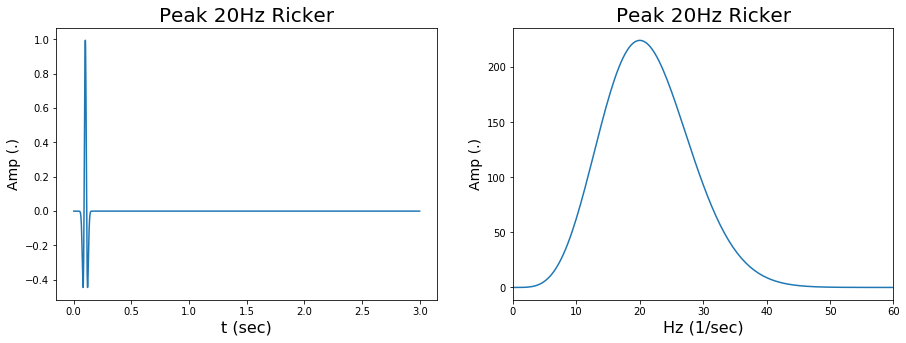

In [7]:
#generate ricker #################################################################################
f_peak=csts['f0']
t_min = -2/(f_peak)
length=csts['dt']*csts['NT']
dt=csts['dt']
df=dt/length/dt
t = np.arange(-length/2, (length-dt)/2, dt)
#t = np.arange(t_min, -t_min, dt)
y = (1.0 - 2.0*(np.pi**2)*(f_peak**2)*(t**2)) * np.exp(-(np.pi**2)*(f_peak**2)*(t**2))
hz = np.fft.fft(y)[:y.shape[0]/2]
f = np.arange(0,hz.shape[0]*df,df)

#shift so spike is at beginning 
shift_flt = -(length/2)-t_min
shift_int = int(shift_flt/dt)
t += length/2
ricker = np.roll(y,int(shift_int))

#get highest frequency value
hz2=(hz*hz).real
temp = np.zeros((hz2.shape))
temp[hz2 > 0.00001] = 1
max_freq = np.nonzero(temp)[-1][-1]*df
print('Max hz: ' + str(max_freq))
print('dt: ' + str(csts['dt']))

dispersion = (vp_min)/max_freq/csts["dh"]
csts['fmax']=max_freq 
print("Dispersion = "+ str(dispersion))

ds = int((1/(2*max_freq))/csts['dt'])
print(ds)

#PLOT #################################################################################
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1,2,1, adjustable='box')
ax2 = fig.add_subplot(1,2,2,adjustable='box')

ax1.plot(t,ricker)
ax1.set_title('Peak ' + str(f_peak) + 'Hz Ricker' , fontsize=20)
ax1.set_xlabel('t (sec)', fontsize=16)
ax1.set_ylabel('Amp (.)', fontsize=14)

ax2.plot(f[0:hz.shape[0]],hz*hz)
ax2.set_xlim([0,60])
ax2.set_title('Peak ' + str(f_peak) + 'Hz Ricker' , fontsize=20)
ax2.set_xlabel('Hz (1/sec)', fontsize=16)
ax2.set_ylabel('Amp (.)', fontsize=14)

#reshape for gabriels format
ricker = np.reshape(ricker,[len(ricker),1])

### Add source signature to constants with source in the center and receiver positions

In [8]:
for ii in range(csts['nab']+5,csts['NX']-2*csts['nab']-10,1000):
    toappend=np.zeros((5,1))
    toappend[0,:]=(csts['NX']/2)*csts['dh']  # x position
    toappend[1,:]=0                       # y position
    toappend[2,:]=(6)*csts['dh']   # z position
    toappend[3,:]=ii               # Source id
    toappend[4,:]=1                # source type
    csts['src_pos']=np.append(csts['src_pos'], toappend, axis=1)
    csts['src']=np.append(csts['src'], ricker  , axis=1)
    
    toappend=np.stack([gx,      # x position
                       gx*0,    # y position
                       gz,      # z position
                       gz*0+ii, # source id  
                       np.arange(0,len(gx))+csts['rec_pos'].shape[1]+1, # rec id (unique to each receiver)
                       gx*0+2,    # For future use (idk what these are just dont touch them)
                       gx*0,    # For future use   (idk what these are just dont touch them)
                       gx*0],   # For future use   (idk what these are just dont touch them)
                       0)
    csts['rec_pos']=np.append(csts['rec_pos'], toappend, axis=1)

### Save the constant file. Every shot will use the same csts file since the only thing changing between experiments are the models used.

In [9]:
h5mat.savemat(filenames['csts'], 
              csts , 
              appendmat=False, format='7.3', 
              store_python_metadata=True, 
              truncate_existing=True)

## Perform experiment for each model

In [ ]:
model_all_filename = model_directory + '/' + model_prefix + '.mat'
models_temp={
        'vp':None,
        'vs':None, 
        'rho':None,
        'water':None}

models_temp["water"] = np.zeros((csts['NZ'],csts['NX']-2*nab))
models_temp["water"][:50,:] = 1

shots={}
for i in np.arange(num_models):
    #start timer
    start = time.time()
    
    #make command to clear
    cmd_clear = 'rm err; rm out; rm SeisCL_dout.mat; rm SeisCL_model.mat;'
    pipes = subprocess.Popen(cmd_clear,stdout=subprocess.PIPE, stderr=subprocess.PIPE,shell=True)
    while (pipes.poll() is None):
        time.sleep(0.5)
    
    #load saved vp model
    dout = h5.File(model_all_filename,'r')
    models_temp['vp']=dout['vp'+str(i)]
    models_temp['vp']=np.transpose(models_temp['vp'][:,:])
    #models_temp['vp'][models_temp['water']==1]=1500;
    
    #pad model
    models_temp['vp'] = np.pad(models_temp['vp'], ((0, 0), (nab, nab)), 'edge')
    
    #generate vs and rho model 
    models_temp['vs']=models_temp['vp']*0 #constant vp/vs ratio of 1.62
    models_temp['rho']=models_temp['vp']*0+2000 #constant 2000 kg/m3
    
    #reshape to appropriate size
    models_temp['vp']=np.reshape(models_temp['vp'], [csts['NZ'],csts['NY'],csts['NX']]) 
    models_temp['vs']=np.reshape(models_temp['vs'], [csts['NZ'],csts['NY'],csts['NX']])
    models_temp['rho']=np.reshape(models_temp['rho'], [csts['NZ'],csts['NY'],csts['NX']])
    
    #save SeisCL model file 
    h5mat.savemat(filenames['model'], 
              models_temp , 
              appendmat=False, 
              format='7.3', 
              store_python_metadata=True, 
              truncate_existing=True)
    time.sleep(0.5)
    
    #make command line arguement
    cmdlaunch='mpirun -np 1 ' + path_to_seisCL + ' '+filepath+'/'+file+' > '+filepath+'/out 2>'+filepath+'/err'
    
    #launch
    pipes = subprocess.Popen(cmdlaunch,stdout=subprocess.PIPE, stderr=subprocess.PIPE,shell=True)
    while (pipes.poll() is None):
        time.sleep(0.5)
    sys.stdout.flush()
    time.sleep(0.5)
    
    #read in shot
    shot_temp_file = h5.File('SeisCL_dout.mat','r')
    shot_temp=shot_temp_file['pout']
    shot_temp=np.transpose(shot_temp[:,:])
    
    #downsample in time
    shot_temp = shot_temp[::ds,:]
    
    #add to dictionary
    (shots['shot_model_'+str(i)]) = shot_temp
    
    #end time
    end = time.time()
    sys.stdout.write('Forward calculation #' + str(i) + ' completed in '+ str(end - start) + ' sec\n')
    
    
filename = shot_output_directory + '/' + shot_output_prefix + '.mat'
h5mat.savemat(filename, 
              shots , 
              appendmat=False, 
              format='7.3', 
              store_python_metadata=True, 
              truncate_existing=True)  

Forward calculation #0 completed in 13.014293670654297 sec
Forward calculation #1 completed in 13.014110088348389 sec
Forward calculation #2 completed in 13.018161058425903 sec
Forward calculation #3 completed in 13.020576477050781 sec
Forward calculation #4 completed in 13.04962420463562 sec
Forward calculation #5 completed in 13.019191980361938 sec
Forward calculation #6 completed in 13.076385498046875 sec
Forward calculation #7 completed in 12.325431823730469 sec
Forward calculation #8 completed in 12.33823561668396 sec
Forward calculation #9 completed in 12.339452743530273 sec
Forward calculation #10 completed in 12.344118118286133 sec
Forward calculation #11 completed in 12.39962649345398 sec
Forward calculation #12 completed in 12.339224100112915 sec
Forward calculation #13 completed in 12.323025465011597 sec
Forward calculation #14 completed in 12.313641786575317 sec
Forward calculation #15 completed in 12.317344665527344 sec
Forward calculation #16 completed in 12.3266344070434

Forward calculation #137 completed in 12.446053266525269 sec
Forward calculation #138 completed in 12.451181650161743 sec
Forward calculation #139 completed in 12.46920132637024 sec
Forward calculation #140 completed in 12.424590587615967 sec
Forward calculation #141 completed in 12.43368411064148 sec
Forward calculation #142 completed in 12.41949725151062 sec
Forward calculation #143 completed in 12.376454591751099 sec
Forward calculation #144 completed in 12.418349742889404 sec
Forward calculation #145 completed in 12.414013385772705 sec
Forward calculation #146 completed in 12.393873691558838 sec
Forward calculation #147 completed in 12.417606353759766 sec
Forward calculation #148 completed in 12.408281087875366 sec
Forward calculation #149 completed in 12.428205490112305 sec
Forward calculation #150 completed in 12.420081377029419 sec
Forward calculation #151 completed in 12.429815292358398 sec
Forward calculation #152 completed in 12.447707414627075 sec
Forward calculation #153 co

Forward calculation #272 completed in 12.540952682495117 sec
Forward calculation #273 completed in 12.52941632270813 sec
Forward calculation #274 completed in 12.53600001335144 sec
Forward calculation #275 completed in 12.538403749465942 sec
Forward calculation #276 completed in 12.527404546737671 sec
Forward calculation #277 completed in 12.51590895652771 sec
Forward calculation #278 completed in 12.514289379119873 sec
Forward calculation #279 completed in 12.53380537033081 sec
Forward calculation #280 completed in 12.576163291931152 sec
Forward calculation #281 completed in 12.53356385231018 sec
Forward calculation #282 completed in 12.546180725097656 sec
Forward calculation #283 completed in 12.516212463378906 sec
Forward calculation #284 completed in 12.55059266090393 sec
Forward calculation #285 completed in 12.531075477600098 sec
Forward calculation #286 completed in 12.583776950836182 sec
Forward calculation #287 completed in 12.551258563995361 sec
Forward calculation #288 compl

In [ ]:
test_example = 902
filename_test = filename
dout = h5.File(filename_test,'r')

p_el=dout['shot_model_'+str(test_example)]
#p_el=dout['pout']
p_el=np.transpose(p_el[:,:])
print(p_el.shape)

clip=0.05;
vmin=np.min(p_el)*clip;
vmax=np.max(p_el)*clip;
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(p_el[:,:], 
               interpolation='bilinear', 
               vmin=vmin, 
               vmax=vmax, 
               cmap=plt.get_cmap('Greys'), 
               aspect='auto',
               origin='upper',
               extent=[0,6, p_el.shape[0]*csts['dt'],0]
               )
fig.suptitle('Pressure recording at surface', fontsize=20)
plt.xlabel('x (km)', fontsize=16)
plt.ylabel('Time (ms)', fontsize=14)
plt.show()

### grab one model and write to file

### change output prefix

### run SeisCL

### read shot data back in and downsample in time and space. Rewrite to same filename